**
This is a simple YOLO V1 implementation from scratch in tensorflow to detect drones in images trained on a very small dataset of labelled drone images with bounding boxes** 

In [0]:
!pip install tensorflow-gpu



connecting and mounting google drive to get data and save models 

In [0]:
# Load the Drive helper and mount
from google.colab import drive

# This will prompt for authorization.
drive.mount('/content/drive/')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3Aietf%3Awg%3Aoauth%3A2.0%3Aoob&scope=email%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdocs.test%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive.photos.readonly%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fpeopleapi.readonly&response_type=code

Enter your authorization code:
··········
Mounted at /content/drive/


In [0]:
!cd "/content/drive/My Drive/yolo_drone"


# New Section

In [0]:
#my own implementation of yolo - for faces or other custom objects
import tensorflow as tf
import numpy as np

In [0]:
Xinput=tf.placeholder(shape=[None,500,500,3],dtype=tf.float32,name='input')
ypc=tf.placeholder(shape=[None,10,10,1],dtype=tf.float32,name='object_prob')
ywd=tf.placeholder(shape=[None,10,10,1],dtype=tf.float32,name='object_rel_width')
yht=tf.placeholder(shape=[None,10,10,1],dtype=tf.float32,name='object_rel_height')
ycx=tf.placeholder(shape=[None,10,10,1],dtype=tf.float32,name='object_rel_xcenter')
ycy=tf.placeholder(shape=[None,10,10,1],dtype=tf.float32,name='object_rel_ycenter')
yflat=tf.placeholder(shape=[None,500],dtype=tf.float32,name='object_all_flat')

scaling_filter = tf.constant(1/255.0,shape=[1,1,3])
#input_Scaled=tf.nn.conv2d(Xinput,scaling_filter,strides=[1,1,1,1],padding='SAME')

input_Scaled = tf.multiply(scaling_filter,Xinput)


w0=tf.get_variable('w0', shape=(3,3,3,32), initializer=tf.contrib.layers.xavier_initializer())
b0=tf.get_variable('b0', shape=(32), initializer=tf.contrib.layers.xavier_initializer())
l0 = tf.add(tf.nn.conv2d(input_Scaled, w0,strides=[1,1,1,1],padding='SAME'),b0)
l0 = tf.nn.relu(l0) 

w1=tf.get_variable('w1', shape=(3,3,32,128), initializer=tf.contrib.layers.xavier_initializer())
b1=tf.get_variable('b1', shape=(128), initializer=tf.contrib.layers.xavier_initializer())
l1 = tf.add(tf.nn.conv2d(l0, w1,strides=[1,1,1,1],padding='VALID'),b1)
l1 = tf.nn.leaky_relu(l1) 

w2=tf.get_variable('w2', shape=(3,3,128,128), initializer=tf.contrib.layers.xavier_initializer())
b2=tf.get_variable('b2', shape=(128), initializer=tf.contrib.layers.xavier_initializer())
l2 = tf.add(tf.nn.conv2d(l1, w2,strides=[1,2,2,1],padding='VALID'),b2)
l2 = tf.nn.leaky_relu(l2) 

w3=tf.get_variable('w3', shape=(3,3,128,128), initializer=tf.contrib.layers.xavier_initializer())
b3=tf.get_variable('b3', shape=(128), initializer=tf.contrib.layers.xavier_initializer())
l3 = tf.add(tf.nn.conv2d(l2, w3,strides=[1,2,2,1],padding='VALID'),b3)
l3 = tf.nn.leaky_relu(l3) 

w4=tf.get_variable('w4', shape=(3,3,128,32), initializer=tf.contrib.layers.xavier_initializer())
b4=tf.get_variable('b4', shape=(32), initializer=tf.contrib.layers.xavier_initializer())
l4 = tf.add(tf.nn.conv2d(l3, w4,strides=[1,2,2,1],padding='VALID'),b4)
l4 = tf.nn.leaky_relu(l4) 

w5=tf.get_variable('w5', shape=(3,3,32,32), initializer=tf.contrib.layers.xavier_initializer())
b5=tf.get_variable('b5', shape=(32), initializer=tf.contrib.layers.xavier_initializer())
l5 = tf.add(tf.nn.conv2d(l4, w5,strides=[1,2,2,1],padding='VALID'),b5)
l5 = tf.nn.leaky_relu(l5) 

w6=tf.get_variable('w6', shape=(3,3,32,32), initializer=tf.contrib.layers.xavier_initializer())
b6=tf.get_variable('b6', shape=(32), initializer=tf.contrib.layers.xavier_initializer())
l6 = tf.add(tf.nn.conv2d(l5, w6,strides=[1,2,2,1],padding='VALID'),b6)
l6 = tf.nn.leaky_relu(l6) #14,14,128
 
w7=tf.get_variable('w7', shape=(3,3,32,16), initializer=tf.contrib.layers.xavier_initializer())
b7=tf.get_variable('b7', shape=(16), initializer=tf.contrib.layers.xavier_initializer())
l7 = tf.add(tf.nn.conv2d(l6, w7,strides=[1,1,1,1],padding='VALID'),b7)
l7 = tf.nn.leaky_relu(l7)#12,12,128
#####################################################################################################
wpc=tf.get_variable('wpc', shape=(3,3,16,1), initializer=tf.contrib.layers.xavier_initializer())
bpc=tf.get_variable('bpc', shape=(1), initializer=tf.contrib.layers.xavier_initializer())
lpc = tf.add(tf.nn.conv2d(l7, wpc,strides=[1,1,1,1],padding='VALID'),bpc)
lpc = tf.nn.sigmoid(lpc)#10,10,1
    
wwd=tf.get_variable('wwd', shape=(3,3,16,1), initializer=tf.contrib.layers.xavier_initializer())
bwd=tf.get_variable('bwd', shape=(1), initializer=tf.contrib.layers.xavier_initializer())
lwd = tf.add(tf.nn.conv2d(l7, wwd,strides=[1,1,1,1],padding='VALID'),bwd)
lwd = tf.nn.sigmoid(lwd)#10,10,1

wht=tf.get_variable('wht', shape=(3,3,16,1), initializer=tf.contrib.layers.xavier_initializer())
bht=tf.get_variable('bht', shape=(1), initializer=tf.contrib.layers.xavier_initializer())
lht = tf.add(tf.nn.conv2d(l7, wht,strides=[1,1,1,1],padding='VALID'),bht)
lht = tf.nn.sigmoid(lht)#10,10,1


wcx=tf.get_variable('wcx', shape=(3,3,16,1), initializer=tf.contrib.layers.xavier_initializer())
bcx=tf.get_variable('bcx', shape=(1), initializer=tf.contrib.layers.xavier_initializer())
lcx = tf.add(tf.nn.conv2d(l7, wcx,strides=[1,1,1,1],padding='VALID'),bcx)
lcx = tf.nn.sigmoid(lcx)#10,10,1

wcy=tf.get_variable('wcy', shape=(3,3,16,1), initializer=tf.contrib.layers.xavier_initializer())
bcy=tf.get_variable('bcy', shape=(1), initializer=tf.contrib.layers.xavier_initializer())
lcy = tf.add(tf.nn.conv2d(l7, wcy,strides=[1,1,1,1],padding='VALID'),bcy)
lcy = tf.nn.sigmoid(lcy)#10,10,1
####################################################################
flat=tf.reshape(l7,[-1,12*12*16]) #flat1=tf.reshape(l11a,[-1,120*200*10])
wf=tf.get_variable('wf', shape=(12*12*16,500), initializer=tf.contrib.layers.xavier_initializer())
bf=tf.get_variable('bf', shape=(500), initializer=tf.contrib.layers.xavier_initializer())
lf = tf.add(tf.matmul(flat,wf),bf)
lf = tf.nn.sigmoid(lf)#none,500





For more information, please see:
  * https://github.com/tensorflow/community/blob/master/rfcs/20180907-contrib-sunset.md
  * https://github.com/tensorflow/addons
If you depend on functionality not listed there, please file an issue.

Instructions for updating:
Colocations handled automatically by placer.


In [0]:
#loss func

# masking unecessary stuff
lpcobj = tf.multiply(ypc,lpc)#masking
bcgrnd=tf.ones([10,10,1]) - ypc # we need to 5 times the loss where object is and 0.05 times the loss where object is not
#masking other outputs
lpcbcgrnd= tf.multiply(bcgrnd,lpc)
lwdobj= tf.multiply(lwd,ypc)
lhtobj= tf.multiply(lht,ypc)
lcxobj= tf.multiply(lcx,ypc)
lcyobj= tf.multiply(lcy,ypc)
cplx_loss= tf.reduce_sum(5*tf.square(ypc-lpcobj)+0.5*tf.square(lpcbcgrnd) + 0.5*tf.square(lwdobj- ywd)+ 0.5*tf.square(lhtobj- yht) + 0.5*tf.square(lcxobj- ycx) + 0.5*tf.square(lcyobj- ycy))
# this loss function will make prob ojb more important and then boxes with high actual obj will be taken for loss for size and locationof center rest everythig is ignored 
#i.e. we are only imporving predictions where object is and and then imporving size and loc prediction in places having objects #i dont know if it will be better 
simpl_loss= tf.reduce_sum(tf.square(lf - yflat))
optimiser=tf.train.AdamOptimizer(learning_rate=0.001,name='Adam')
complex_train_op=optimiser.minimize(cplx_loss)
simple_train_op = optimiser.minimize(simpl_loss)

In [0]:
input_img=np.load('/content/drive/My Drive/yolo_drone/x_yolo.npy')
y_pc=np.load('/content/drive/My Drive/yolo_drone/y_pc.npy')
y_wd=np.load('/content/drive/My Drive/yolo_drone/y_wd.npy')
y_ht=np.load('/content/drive/My Drive/yolo_drone/y_ht.npy')
y_cx=np.load('/content/drive/My Drive/yolo_drone/y_cx.npy')
y_cy=np.load('/content/drive/My Drive/yolo_drone/y_cy.npy')
y_flat=np.load('/content/drive/My Drive/yolo_drone/y_flat.npy')

In [0]:
#saver

Trained it to over fit just to check that if the model is deep enough or not

In [0]:
saver = tf.train.Saver()
with tf.Session() as sess:
	#sess.run(tf.global_variables_initializer())
	savepath= "/content/drive/My Drive/yolo_drone/simplemodel/dronenet.ckpt"
	
	#restore dont run initializer
	saver.restore(sess,savepath)
	mini_batch=8
	batch=len(input_img)
	epochs=20
	for j in range (epochs):
		for x in range (0,batch,mini_batch):
			if x<(int(batch/mini_batch)*mini_batch):
				image= input_img[x:mini_batch+x]	
				pc= y_pc[x:mini_batch+x]

				wd = y_wd[x:mini_batch+x]	
				ht= y_ht[x:mini_batch+x]
				cx= y_cx[x:mini_batch+x]
				cy = y_cy[x:mini_batch+x]
				flat = y_flat[x:mini_batch+x]
			if x==(int(batch/mini_batch)*mini_batch):
				image= input_img[x:batch]	
				pc= y_pc[x:batch]

				wd = y_wd[x:batch]	
				ht= y_ht[x:batch]
				cx= y_cx[x:batch]
				cy = y_cy[x:batch]
				flat = y_flat[x:batch]	
			print("epoch:",j+1)
			print("batch "+str(x)+"/"+str(batch))
			
				

			#INFERENCE=sess.run([lpcobj,lpcbcgrnd,lwdobj,lhtobj,lcxobj,lcyobj,cplx_loss],feed_dict={Xinput:[image],ypc:[pc],ywd:[wd],yht:[ht],ycx:[cx],ycy:[cy],yflat:[flat]})
			straining = sess.run(simple_train_op,feed_dict={Xinput:image,ypc:pc,ywd:wd,yht:ht,ycx:cx,ycy:cy,yflat:flat})

			#loss = sess.run(cplx_loss,feed_dict={Xinput:image,ypc:pc,ywd:wd,yht:ht,ycx:cx,ycy:cy,yflat:flat})
			loss = sess.run(simpl_loss,feed_dict={Xinput:image,ypc:pc,ywd:wd,yht:ht,ycx:cx,ycy:cy,yflat:flat})

			#ctraining = sess.run(complex_train_op,feed_dict={Xinput:image,ypc:pc,ywd:wd,yht:ht,ycx:cx,ycy:cy,yflat:flat})
			#inpt =sess.run(input_Scaled,feed_dict={Xinput:image,ypc:pc,ywd:wd,yht:ht,ycx:cx,ycy:cy,yflat:flat})
			#print(ctraining)
      
      
      
      
			
			print(loss)
	saver_path=saver.save(sess,savepath)      


# New Section

In [0]:
import matplotlib.pyplot as plt
from matplotlib.patches import Rectangle


Testing the model on Training data Just to  see the degreeof  overfit and **also cos i Dont have testing data**

INFO:tensorflow:Restoring parameters from /content/drive/My Drive/yolo_drone/models/dronenet.ckpt
58
0.21281844
(353.43579798936844, 218.09077948331833) 106.4092218875885 191.28018617630005


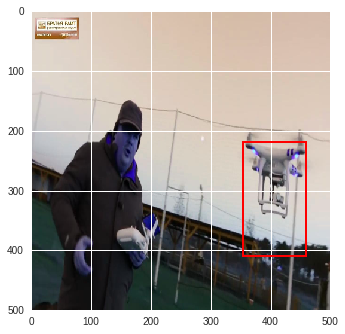

In [108]:
saver = tf.train.Saver()
with tf.Session() as sess:
  savepath= "/content/drive/My Drive/yolo_drone/models/dronenet.ckpt"
	#restore dont run initializer
  saver.restore(sess,savepath)
  example=50
  image= input_img[example]
  pred=sess.run([lpc,lwd,lht,lcx,lcy],feed_dict={Xinput:[image]})
  INFERENCE=pred
        
  
  pc=INFERENCE[0].ravel()
  wd=INFERENCE[1].ravel()
  ht=INFERENCE[2].ravel()
  cx=INFERENCE[3].ravel()
  cy=INFERENCE[4].ravel()
  data=y_pc[example].ravel()
  pred_box_c=[]
  pred_box_w=[]
  pred_box_h=[]
  for i in range(0,len(pc)):
    if pc[i]>0.5:
      print(i)
      xp=(i%10+cx[i])*50 - wd[i]*250
      yp=(i/10+cy[i])*50 - ht[i]*250
      print(wd[i])
      pred_box_c.append((xp,yp))
      pred_box_w.append(wd[i]*500)
      pred_box_h.append(ht[i]*500 )
  
  for i in range(len(pred_box_c)):
    print(pred_box_c[i], pred_box_w[i],pred_box_h[i])
    rect = Rectangle(pred_box_c[i], pred_box_w[i],pred_box_h[i],linewidth=2,edgecolor='r',facecolor='none')
    #rect_test = Rectangle((0, 0), pred_box_w[i],pred_box_h[i],linewidth=2,edgecolor='b',facecolor='none')
    plt.gca().add_patch(rect)
  plt.imshow(image)
  plt.show()
      
  
  

the model is not working properly but can be imporved a lot (i forgot to mention that  i am too  lazy and maybe i will update it after a few months ; -) ) 

link to my project on google drive 

https://drive.google.com/drive/folders/1xbSZ-x6NNzsYISkaMuBBY0fTqMcDUf40?usp=sharing